In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
from statsmodels.nonparametric.kernel_regression import KernelReg

<Axes: xlabel='x1', ylabel='x2'>

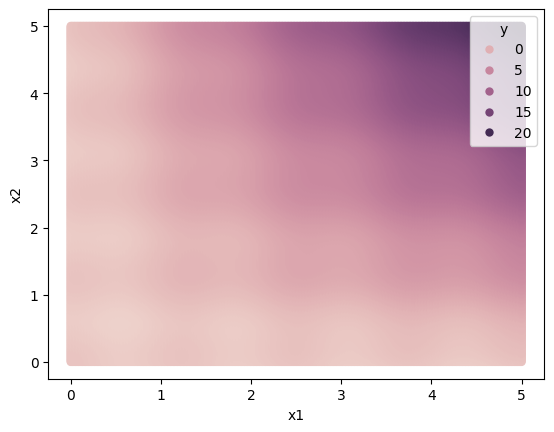

In [2]:


L = 300
H = 5

X1 = np.linspace(0,H,L)
X2 = np.linspace(0,H,L)


def mu(x1,x2):
    tau = .5
    D = 3
    y = x1 * x2 - tau * ( 1 - np.cos( 5*x1) - np.cos(5*x2))-D
    return y

dat = []
for i in range(L):
    for j in range(L):
        y_ij = mu(X1[i],X2[j])
        dat.append([X1[i],X2[j],y_ij])

df = pd.DataFrame(dat, columns = ['x1','x2','y'])
sns.scatterplot(x = 'x1', y= 'x2', hue = 'y', data=df, linewidth=0)

<Axes: xlabel='x1', ylabel='x2'>

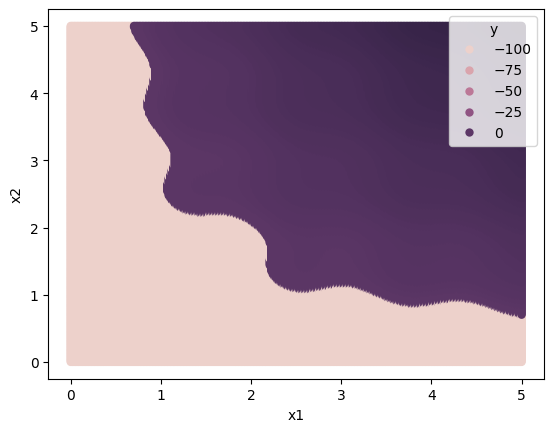

In [3]:
tdf = pd.DataFrame(dat, columns = ['x1','x2','y'])
tdf.loc[ tdf['y']<0,'y'] = -100
sns.scatterplot(x = 'x1', y= 'x2', hue = 'y', data=tdf, linewidth=0)

[[4.17490815 2.6693807 ]
 [2.98277013 4.94896689]
 [1.44431621 2.11797405]
 ...
 [4.14961146 2.14197836]
 [0.14386865 1.3388491 ]
 [0.80344556 3.72975735]]


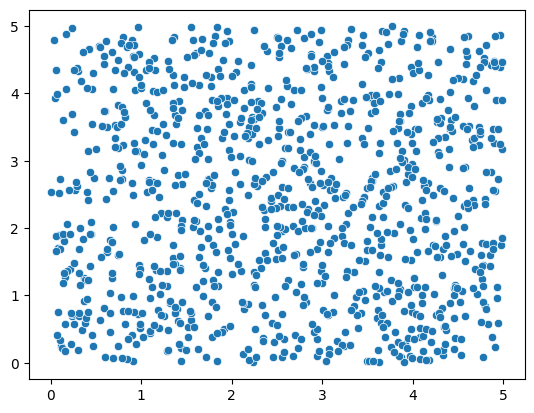

In [4]:

## Sample the square

N = 1000
rng = np.random.default_rng(seed = 100)

X1 = rng.uniform(low=0,high=H,size=N)
X2 = rng.uniform(low=0,high=H,size=N)

X = np.array([X1,X2]).T

sns.scatterplot(x=X1,y=X2)

print(X)

<Axes: >

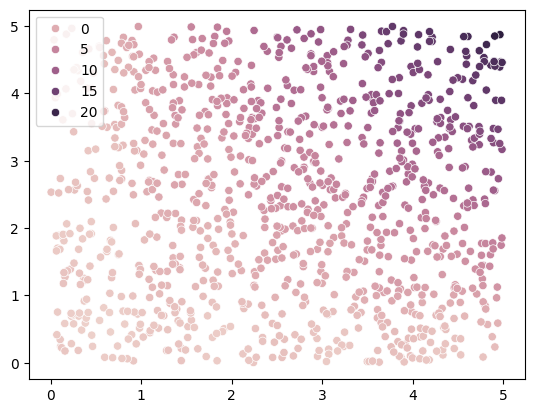

In [5]:
y_true = mu(X1,X2)
sns.scatterplot(x=X1,y=X2,hue=y_true)

[Text(0.5, 1.0, 'Initial Policy')]

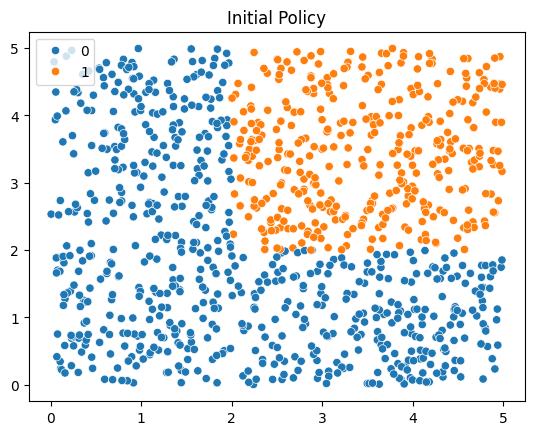

In [6]:
## Initial Policy:
policy_old =  np.array( (X1>2)*(X2>2) ).astype(int) 
sns.scatterplot(x=X1,y=X2,hue=policy_old).set(title='Initial Policy')

[Text(0.5, 1.0, 'Initial Value Function')]

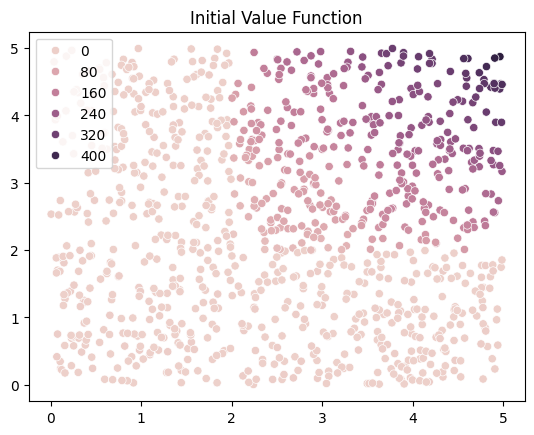

In [7]:
## Simulate V:

T = 1000
rng = np.random.default_rng(seed = 100)
mean = 0.0
sigma = .5
beta = .95
V = np.zeros(N)

for t in range(T):
    shocks_t = rng.normal(loc=mean,scale=sigma,size=N)    
    u_t = y_true*policy_old + shocks_t
    V = u_t + beta*V
    
sns.scatterplot(x=X1,y=X2,hue=V).set(title='Initial Value Function')


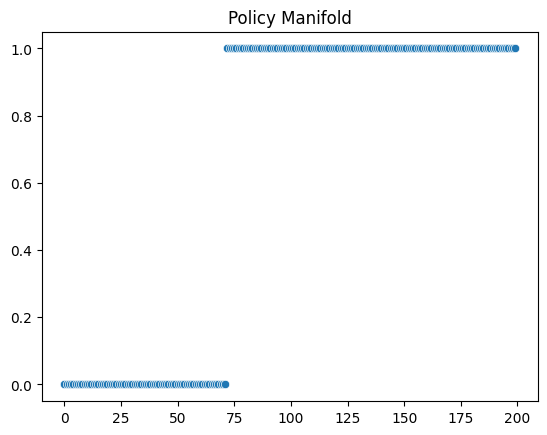

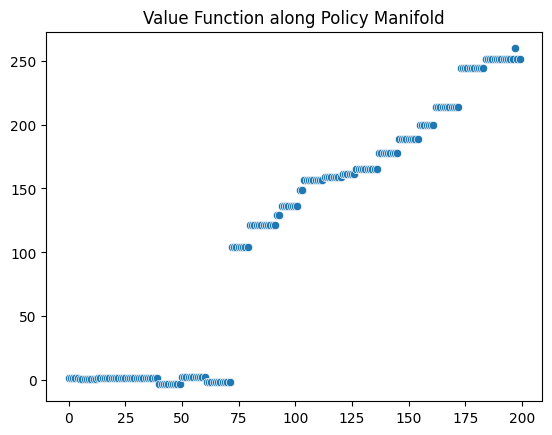

In [8]:
## Investigate Curve

from sklearn.neighbors import KNeighborsRegressor

K_nn = 1
reg_V = KNeighborsRegressor(n_neighbors=K_nn)
reg_V.fit(X,V)
reg_p = KNeighborsRegressor(n_neighbors=K_nn)
reg_p.fit(X,policy_old)

initial_point = np.array([4,1])
final_point = np.array([4,4])
N_curve = 200

curve = np.array( [ np.linspace(initial_point[0],final_point[0],N_curve),np.linspace(initial_point[1],final_point[1],N_curve) ]).T
#length = np.sqrt(  )
V_hat = reg_V.predict(curve)
p_hat = reg_p.predict(curve)

sns.scatterplot(p_hat).set(title='Policy Manifold')
plt.show()
sns.scatterplot(V_hat).set(title='Value Function along Policy Manifold')
plt.show()



[Text(0.5, 1.0, 'Policy Boundary')]

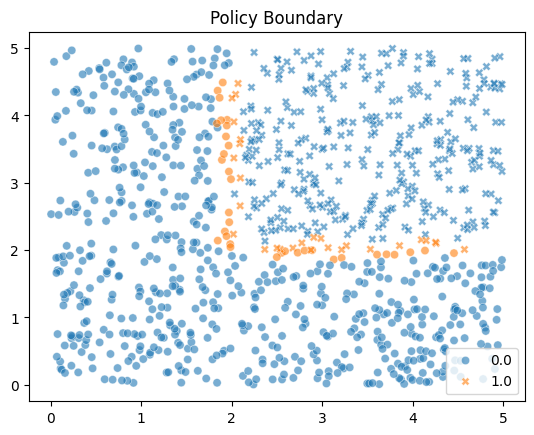

In [9]:
## Detect Policy Boundary:

delta = .2
policy_bndry = np.zeros(N)

for i in range(N):
    #i = 19
    d_i = np.linalg.norm( X[i] - X, axis=1)
    nbhd_i = np.where(d_i < delta)
    mean_i = np.mean(policy_old[nbhd_i])

    if mean_i > 0 and mean_i < 1:
        policy_bndry[i] = 1

sns.scatterplot(x=X1,y=X2,hue=policy_bndry,
                style=policy_old,
                alpha=.6).set(title='Policy Boundary')

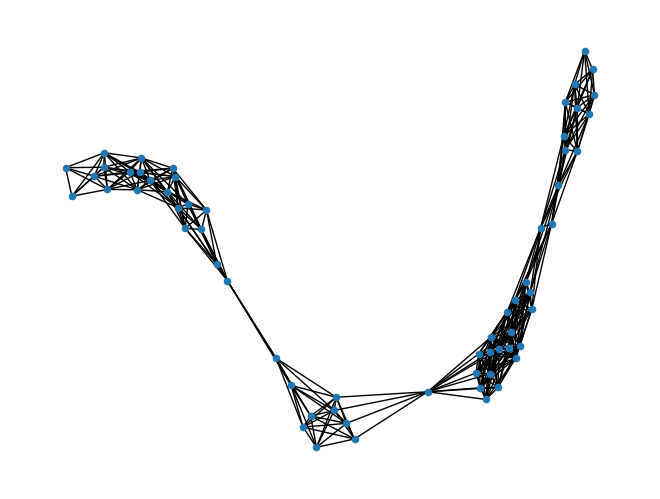

3.646638049933401


[17, 41]

In [10]:
## Experimental Net: Put the points far enough apart to detect an effect?
## Don't want tests of discontinuity correlated with test stat
## Experimental coverage versus topological coverage: Weight future sampling inversely to past coverage?
## Experimental net should be driven by sample size considerations

bndry_fraction = .05

bndry_length = int(np.sum(policy_bndry))
bndry_sample_size = np.floor(bndry_fraction*bndry_length)

## Treat it as a graph, where points have to go through the nearest points to travel
## Then within that graph structure, find bss points 

adjacency = np.zeros((bndry_length,bndry_length))

X_bndry = X[policy_bndry.astype(bool),:]
delta = .5

## Compute delta-neighborhoods:
for i in range(bndry_length):
    X_bndry_i = X_bndry.copy()
    X_bndry_i[i,:]=np.array([ 10e5, 10e5])
    d_i = np.linalg.norm( X_bndry[i] - X_bndry_i, axis=1)
    nn_i = np.where(d_i < delta)
    adjacency[i,nn_i] = 1

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=20)
    plt.show()
show_graph_with_labels(adjacency)

## Compute max_dist pair:
max_pair = []
max_dist = 0
for i in range(bndry_length):
    X_bndry_i = X_bndry.copy()
    d_i = np.linalg.norm( X_bndry[i] - X_bndry_i, axis=1)
    if np.max(d_i)>max_dist:
        max_pair = [i, np.where(d_i == np.max(d_i)) ]
        max_dist = np.max(d_i)

print(max_dist)
max_pair[1] = max_pair[1][0][0]
max_pair


In [11]:
high = 1e5
source_node = 17

## Compute arc costs:
arc_cost = np.zeros((len(X_bndry), len(X_bndry)))
for i in range( len(X_bndry) ):
    for j in range( len(X_bndry) ):
        arc_cost[i,j] = (1-adjacency[i,j]) * high + adjacency[i,j] * np.linalg.norm( X_bndry[i] - X_bndry[j] )

## Djikstra's
J_old = np.ones(len(X_bndry)) * high
unvisited = np.ones(len(X_bndry))
J_old = arc_cost[:,source_node]
while np.sum(unvisited) > 0:
    temp_J = unvisited*J_old + (1-unvisited)*high
    current_node = np.where( temp_J == np.min(temp_J) ) [0][0]
    unvisited[current_node] = 0
    J_new = np.fmin( J_old, J_old[current_node] + arc_cost[:,current_node] ) * unvisited + J_old * (1-unvisited)
    J_old = J_new
d_net = J_old

[Text(0.5, 1.0, 'Experimental Net')]

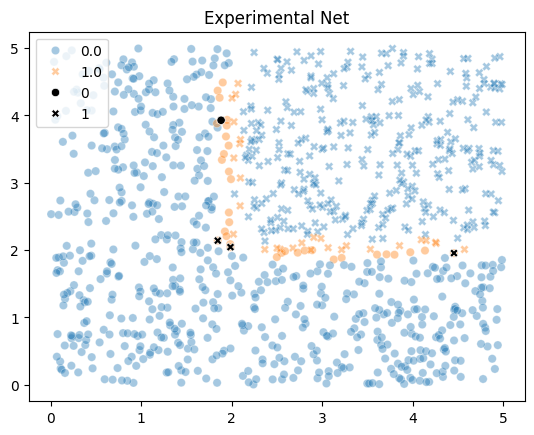

In [12]:
# segment_length = max_dist/(bndry_sample_size+2)
# delta = .3
# # Find points in a delta-window away from current point, select one at random, proceed
# xp_net = [max_pair[0]]
# i = 1
# while i < bndry_sample_size+1 : # Must be along the graph though
#     d_i = np.linalg.norm( X_bndry[xp_net[0]] - X_bndry_i, axis=1)    
#     candidates = np.where( np.abs( d_i - i*segment_length )  < delta )
#     new_point = np.random.choice(candidates[0])
#     xp_net.append(new_point)
#     i+=1
# xp_net = xp_net[1:]
# xp_net = X_bndry[xp_net]


# segment_length = np.max(d_net)/(bndry_sample_size+1)
# delta = .2
# # Find points in a delta-window away from current point, select one at random, proceed
# xp_net = [source_node]
# i = 1
# while i < bndry_sample_size+1 : # Must be along the graph though
#     #d_i = np.linalg.norm( X_bndry[xp_net[0]] - X_bndry_i, axis=1)    
#     candidates = np.where(  (d_net - (i-1)*segment_length>0) * (d_net - i*segment_length   < delta) )
#     new_point = np.random.choice(candidates[0])
#     xp_net.append(new_point)
#     i+=1
# xp_net = xp_net[1:]
# xp_net = X_bndry[xp_net]


## Pick an experimental net:
segment_length = max_dist/(bndry_sample_size)
xp_index = []
for k in range( int(bndry_sample_size)+1 ):
    window = (d_net > segment_length*(k)) * (d_net <= segment_length*(k+1))
    select = rng.integers(1,np.sum(window))
    index = np.where( np.cumsum(window) == select )[0][0]
    xp_index.append( index )

xp_net = X_bndry[xp_index]

sns.scatterplot(x=X1,y=X2,alpha=.4,hue=policy_bndry,style=policy_old)
sns.scatterplot(x=xp_net[:,0],y=xp_net[:,1],style=policy_old[xp_index],color='black').set(title='Experimental Net')

[Text(0.5, 1.0, 'Initial Value Function')]

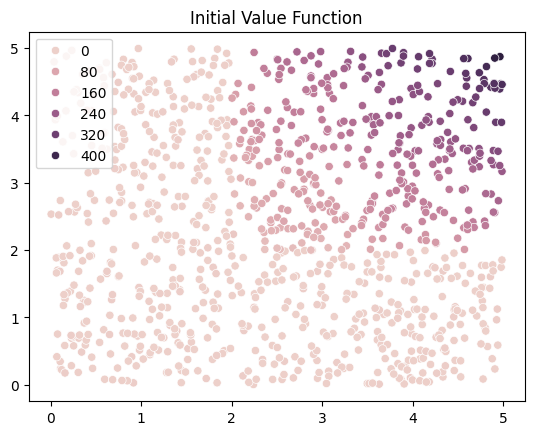

In [13]:
## Run the policy function for T periods to gather evidence

T = 1000
rng = np.random.default_rng(seed = 200)
mean = 0.0
sigma = .5
beta = .95
V = np.zeros(N)

for t in range(T):
    shocks_t = rng.normal(loc=mean,scale=sigma,size=N)    
    u_t = y_true*policy_old + shocks_t
    V = u_t + beta*V
    
sns.scatterplot(x=X1,y=X2,hue=V).set(title='Initial Value Function')

In [14]:


data_1 = pd.DataFrame({ 'V':V[policy_old==1],
                       'x1':X1[policy_old==1],
                        'x2':X2[policy_old==1],    })


data_0 = pd.DataFrame({ 'V':V[policy_old==0],
                       'x1':X1[policy_old==0],
                        'x2':X2[policy_old==0],    })

def RDD_reg(xp_point, X, V, policy_old):
    Z = X - xp_point
    ## Upper regression
    data_1 = pd.DataFrame({ 'V':V[policy_old==1],
                        'z1':Z[policy_old==1,0],
                            'z2':Z[policy_old==1, 1],    })
    reg_1 = KernelReg(endog = V[policy_old==1],
                    exog = data_1.drop('V',axis=1),
                    var_type = ['c','c'])
    tau_upper = reg_1.fit([0,0])[0]
    ## Lower regression
    data_0 = pd.DataFrame({ 'V':V[policy_old==0],
                        'z1':Z[policy_old==0,0],
                            'z2':Z[policy_old==0, 1],    })
    reg_1 = KernelReg(endog = V[policy_old==0],
                    exog = data_0.drop('V',axis=1),
                    var_type = ['c','c'])
    tau_lower = reg_1.fit([0,0])[0]
    ## Effect size:
    effect = tau_upper - tau_lower
    return effect

net_fx = []
for j in range( len(xp_net) ):
    print( str(j) +' of '+ str( len(xp_net) ) )
    fx_j = RDD_reg( xp_net[j], X, V, policy_old)
    net_fx.append( fx_j )


0 of 4
1 of 4
2 of 4
3 of 4


<Axes: >

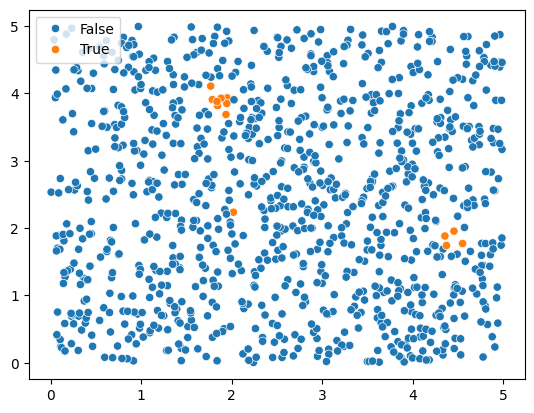

In [ ]:
## Construct new policy

# Replace tolerance with a significance test
# Replace step size with a confident interval

policy_new = policy_old.copy()
delta = .25
tol = .05

for k in range(len(net_fx)):
    if net_fx[k]>tol:
        d_k = np.linalg.norm( xp_net[k,:] - X, axis=1)
        nbhd_k = np.where(d_k < delta)
        policy_new[nbhd_k] = 1
    elif net_fx[k]<tol:
        d_k = np.linalg.norm( xp_net[k,:] - X, axis=1)
        nbhd_k = np.where(d_k < delta)
        policy_new[nbhd_k] = 0

policy_delta = ( policy_new != policy_old )


sns.scatterplot( x=X1,y=X2,hue=policy_delta)

In [18]:
## Stopping criteria: No big jumps found, so policy converges

stop_now = np.array_equal( policy_new, policy_old)
